## Modeling Survival on the Titanic

In [1]:
import pandas as pd
import numpy as np
import re
import pickle

In [2]:
import plotly as py
import plotly.graph_objs as go

In [3]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [4]:
# Define the color palette 
Viridis=[
"#440154", "#440558", "#450a5c", "#450e60", "#451465", "#461969",
"#461d6d", "#462372", "#472775", "#472c7a", "#46307c", "#45337d",
"#433880", "#423c81", "#404184", "#3f4686", "#3d4a88", "#3c4f8a",
"#3b518b", "#39558b", "#37598c", "#365c8c", "#34608c", "#33638d",
"#31678d", "#2f6b8d", "#2d6e8e", "#2c718e", "#2b748e", "#29788e",
"#287c8e", "#277f8e", "#25848d", "#24878d", "#238b8d", "#218f8d",
"#21918d", "#22958b", "#23988a", "#239b89", "#249f87", "#25a186",
"#25a584", "#26a883", "#27ab82", "#29ae80", "#2eb17d", "#35b479",
"#3cb875", "#42bb72", "#49be6e", "#4ec16b", "#55c467", "#5cc863",
"#61c960", "#6bcc5a", "#72ce55", "#7cd04f", "#85d349", "#8dd544",
"#97d73e", "#9ed93a", "#a8db34", "#b0dd31", "#b8de30", "#c3df2e",
"#cbe02d", "#d6e22b", "#e1e329", "#eae428", "#f5e626", "#fde725"]
# source: https://bhaskarvk.github.io/colormap/reference/colormap.html

### Read in the titanic dataset

In [5]:
df = pd.read_csv('resources/titanic.csv')
# df = pd.read_csv("https://raw.githubusercontent.com/austinlasseter/plotly_dash_tutorial/master/00%20resources/titanic.csv")
print(df.shape)
df.head()

(712, 8)


,Survived,Pclass,Sex,Age,Fare,Embarked,Name,SibSp
0,0,3,male,22.0,7.2500,Southampton,"Braund, Mr. Owen Harris",1
1,1,1,female,38.0,71.2833,Cherbourg,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
2,1,3,female,26.0,7.9250,Southampton,"Heikkinen, Miss. Laina",0
3,1,1,female,35.0,53.1000,Southampton,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
4,0,3,male,35.0,8.0500,Southampton,"Allen, Mr. William Henry",0


### Features

In [6]:
# Make some dummies for sex.
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Sex'])

In [7]:
# Make some dummies Passenger's cabin class
df = pd.get_dummies(df, prefix='Cabin Class', prefix_sep=' ', columns=['Pclass'])

In [8]:
# Make some dummies Passenger's embarkation
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Embarked'])

In [9]:
# Siblings and Spouses
df=df.rename(columns={'SibSp':'Siblings and Spouses'})
df['Siblings and Spouses'].value_counts()

0    469
1    183
2     25
4     18
3     12
5      5
Name: Siblings and Spouses, dtype: int64

In [10]:
# age requires binning
print(df.Age.describe())
print(df.Age.describe()['25%'])

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
20.0


In [11]:
# Age
bins=[1, 20, 28, 38, 80]
df['age_binned']=pd.cut(df['Age'], bins)
df['age_binned'].value_counts().sort_index()

(1, 20]     165
(20, 28]    183
(28, 38]    174
(38, 80]    176
Name: age_binned, dtype: int64

In [12]:
df = pd.get_dummies(df, prefix='Age', prefix_sep=' ', columns=['age_binned'])
df.head(2)

,Survived,Age,Fare,Name,Siblings and Spouses,female,male,Cabin Class 1,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,Southampton,"Age (1, 20]","Age (20, 28]","Age (28, 38]","Age (38, 80]"
0,0,22.0,7.2500,"Braund, Mr. Owen Harris",1,0,1,0,0,1,0,0,1,0,1,0,0
1,1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,0,1,0,0,1,0,0,0,0,1,0


In [13]:
# Name
df['Last Name']=df['Name'].apply(lambda x: x.split(',')[0])
df['First Name']=df['Name'].apply(lambda x: x.split(',')[1])
df['Title']=df['First Name'].apply(lambda x: x.split('.')[0])

In [14]:
# Title
print(df['Title'].value_counts())
df['Mr.']=np.where((df['Title']==' Mr')|(df['Title']==' Master')|(df['Title']==' Ms'), 1, 0) # Ms is actually monsieur
df['Mrs.']=np.where((df['Title']==' Mrs')|(df['Title']==' Mme'), 1, 0)
df['Miss']=np.where((df['Title']==' Miss')|(df['Title']==' Mlle'), 1, 0)
df['VIP']=np.where((df['Mr.']==0)&(df['Mrs.']==0)&(df['Miss']==0), 1, 0)

 Mr              398
 Miss            145
 Mrs             107
 Master           36
 Rev               6
 Dr                6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
Name: Title, dtype: int64


In [15]:
df['VIP'].value_counts()

0    690
1     22
Name: VIP, dtype: int64

In [16]:
# Check for missing values as they will skew the regression
print(df.shape)
df = df.dropna()
print(df.shape)

(712, 24)
(712, 24)


In [17]:
# What are the possible features?
df.columns

Index(['Survived', 'Age', 'Fare', 'Name', 'Siblings and Spouses', 'female',
       'male', 'Cabin Class 1', 'Cabin Class 2', 'Cabin Class 3', 'Cherbourg',
       'Queenstown', 'Southampton', 'Age (1, 20]', 'Age (20, 28]',
       'Age (28, 38]', 'Age (38, 80]', 'Last Name', 'First Name', 'Title',
       'Mr.', 'Mrs.', 'Miss', 'VIP'],
      dtype='object')

In [137]:
# Turns out that fare doesn't add any significant or meaningful coefficient to the final model, so we're dropping it.
feature_cols=list(df.columns)
for item in ['Survived', 'Fare', 'Age', 'Southampton', 'Age (1, 20]', 'Last Name', 'First Name', 'Title', 'Mr.', 'Mrs.', 'Miss', 'VIP']:
    feature_cols.remove(item)
print(feature_cols)

['Name', 'Siblings and Spouses', 'female', 'male', 'Cabin Class 1', 'Cabin Class 2', 'Cabin Class 3', 'Cherbourg', 'Queenstown', 'Age (20, 28]', 'Age (28, 38]', 'Age (38, 80]']


In [138]:
# Select our features
X = df[feature_cols]
y = df.Survived

### Modeling

In [139]:
# Train-test split
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [140]:
X_train1.columns

Index(['Name', 'Siblings and Spouses', 'female', 'male', 'Cabin Class 1',
       'Cabin Class 2', 'Cabin Class 3', 'Cherbourg', 'Queenstown',
       'Age (20, 28]', 'Age (28, 38]', 'Age (38, 80]'],
      dtype='object')

In [141]:
# Remove the names, we'll save those for later use.
X_train=X_train1.drop('Name', axis=1)
X_test=X_test1.drop('Name', axis=1)

In [142]:
X_train.columns

Index(['Siblings and Spouses', 'female', 'male', 'Cabin Class 1',
       'Cabin Class 2', 'Cabin Class 3', 'Cherbourg', 'Queenstown',
       'Age (20, 28]', 'Age (28, 38]', 'Age (38, 80]'],
      dtype='object')

In [143]:
gnb = GaussianNB()
# Fit on the training data
gnb_model = gnb.fit(X_train, y_train)
# Predict on the testing data
predictions=gnb_model.predict(X_test)
probabilities = gnb_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_nb=metrics.roc_auc_score(y_test, predictions)
acc_nb = metrics.accuracy_score(y_test, predictions)
f1_nb = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_nb,4))
print('Accuracy', "%.4f" % round(acc_nb,4))
print('AUC Score', "%.4f" % round(auc_nb,4))

F1 Score 0.7059
Accuracy 0.7552
AUC Score 0.7458


In [144]:
knn = KNeighborsClassifier(n_neighbors=7)
# Fit on the training data
knn_model=knn.fit(X_train, y_train)
# Predict on the testing data
predictions=knn_model.predict(X_test)
probabilities = knn_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_knn=metrics.roc_auc_score(y_test, predictions)
acc_knn = metrics.accuracy_score(y_test, predictions)
f1_knn = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_knn,4))
print('Accuracy', "%.4f" % round(acc_knn,4))
print('AUC Score', "%.4f" % round(auc_knn,4))

F1 Score 0.6842
Accuracy 0.7483
AUC Score 0.7345


In [145]:
rf = RandomForestClassifier()
# Fit on the training data
rf_model=rf.fit(X_train, y_train)
# Predict on the testing data
predictions=rf_model.predict(X_test)
probabilities = rf_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_rf=metrics.roc_auc_score(y_test, predictions)
acc_rf = metrics.accuracy_score(y_test, predictions)
f1_rf = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_rf,4))
print('Accuracy', "%.4f" % round(acc_rf,4))
print('AUC Score', "%.4f" % round(auc_rf,4))

F1 Score 0.6981
Accuracy 0.7762
AUC Score 0.7562


In [136]:
logreg = LogisticRegression()
# Fit on the training data
log_model=logreg.fit(X_train, y_train)
# Predict on the testing data
predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_log=metrics.roc_auc_score(y_test, predictions)
acc_log = metrics.accuracy_score(y_test, predictions)
f1_log = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_log,4))
print('Accuracy', "%.4f" % round(acc_log,4))
print('AUC Score', "%.4f" % round(auc_log,4))

F1 Score 0.7611
Accuracy 0.8112
AUC Score 0.7975


### Comparison of Four Models

In [147]:
# create lists from the metrics we produced.
f1=[f1_nb, f1_log, f1_knn, f1_rf]
acc=[acc_nb, acc_log, acc_knn, acc_rf]
auc=[auc_nb, auc_log, auc_knn, auc_rf]
# Define a function that will round our metrics.
def rounder(metric):
    scores_list=[]
    for score in metric:
        scores_list.append(round(float(score*100),1))
    return scores_list
# Apply it to each of the three lists.
f1_scores=rounder(f1)
acc_scores=rounder(acc)
auc_scores=rounder(auc)
score_types=['F1 score', 'Accuracy', 'AUC score']

In [148]:
# Comparison of model metrics
models=['naive bayes', 'logistic regression', 'k-nearest neighbors', 'random forest']
index=['F1 score', 'Accuracy', 'AUC score']
compare_models=pd.DataFrame([f1_scores, acc_scores, auc_scores], index=index, columns=models)
compare_models

,naive bayes,logistic regression,k-nearest neighbors,random forest
F1 score,70.6,76.1,68.4,69.8
Accuracy,75.5,81.1,74.8,77.6
AUC score,74.6,79.8,73.5,75.6


In [149]:
# save to csv, for later use by plotly dash app.
compare_models.to_csv('resources/compare_models.csv', index=True)
pd.read_csv('resources/compare_models.csv', index_col=0)

,naive bayes,logistic regression,k-nearest neighbors,random forest
F1 score,70.6,76.1,68.4,69.8
Accuracy,75.5,81.1,74.8,77.6
AUC score,74.6,79.8,73.5,75.6


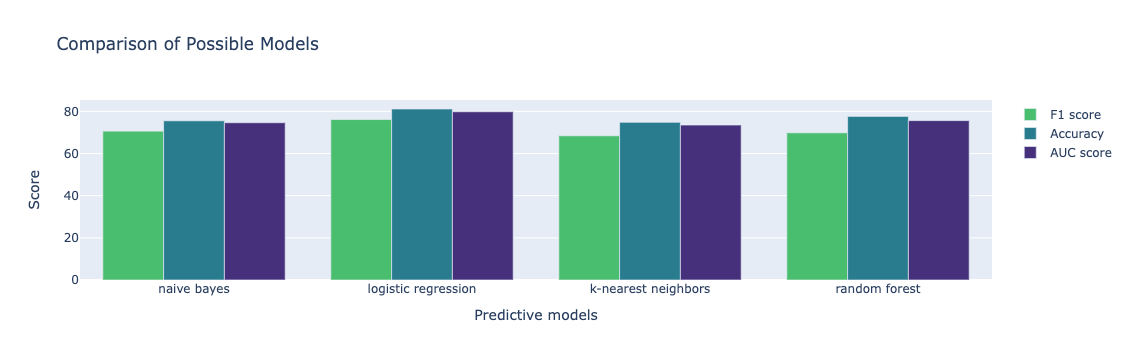

In [150]:
# Let's display that with plotly.
mydata1 = go.Bar(
    x=compare_models.loc['F1 score'].index,
    y=compare_models.loc['F1 score'],
    name=compare_models.index[0],
    marker=dict(color=Viridis[50])
)
mydata2 = go.Bar(
    x=compare_models.loc['Accuracy'].index,
    y=compare_models.loc['Accuracy'],
    name=compare_models.index[1],
    marker=dict(color=Viridis[30])
)
mydata3 = go.Bar(
    x=compare_models.loc['AUC score'].index,
    y=compare_models.loc['AUC score'],
    name=compare_models.index[2],
    marker=dict(color=Viridis[10])
)
mylayout = go.Layout(
    title='Comparison of Possible Models',
    xaxis = dict(title = 'Predictive models'), # x-axis label
    yaxis = dict(title = 'Score'), # y-axis label
    
)
fig = go.Figure(data=[mydata1, mydata2, mydata3], layout=mylayout)
fig

## Tuning the Logistic Classifier
Note: The gridsearch step is included here for completeness sake, as this is a smart inclusion in any iteration of possible models. But for the sake of speed (this notebook was run multiple times during development) I've kept my gridsearch to a bare-bones placeholder. A more complete project would use a broader grid.

In [151]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, decomposition, datasets

std_slc = StandardScaler()
pca = decomposition.PCA()
logistic_Reg = linear_model.LogisticRegression()
# logistic_Reg = linear_model.SGDClassifier(loss='log', penalty='l2', early_stopping=True,
#                          max_iter=10000, tol=1e-5, random_state=0)
pipe = Pipeline(steps=[('std_slc', std_slc),
                       ('pca', pca),
                       ('logistic_Reg', logistic_Reg)])
n_components = list(range(1,X.shape[1]+1,1))
#n_components = [5, 20, 30, 40, 50, 64]
print(n_components)
# Create regularization penalty space (l1=ridge, l2=lasso)
penalty = ['l1', 'l2'] 

# Create regularization hyperparameter space
C = np.logspace(0, 4., 30)
alpha=np.logspace(-4, 4, 5)
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
solver=['newton-cg', 'lbfgs', 'liblinear']

# Create hyperparameter options
#hyperparameters = dict(C=C, penalty=penalty, max_iter=[3000], solver=solver)
hyperparameters = dict(pca__n_components=n_components, logistic_Reg__max_iter=[4000], logistic_Reg__C=C, logistic_Reg__penalty=penalty, logistic_Reg__solver=solver)
#hyperparameters = dict(pca__n_components=n_components, logistic_Reg__alpha=alpha, logistic_Reg__penalty=penalty)
#hyperparameters = dict(bootstrap=[True,False], max_features = ['auto', 'sqrt'], min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_depth=max_depth,n_estimators=n_estimators)

# Create grid search using 5-fold cross validation
print(LogisticRegression().get_params().keys())
print(RandomForestClassifier().get_params().keys())
grid_lr = GridSearchCV(pipe, hyperparameters, cv=10,  n_jobs = 1, verbose=0)
grid_lr.fit(X_train, y_train)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])
dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


8400 fits failed out of a total of 21600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3300 fits failed with the following error:
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-p

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic_Reg', LogisticRegression())]),
             n_jobs=1,
             param_grid={'logistic_Reg__C': array([1.00000000e+00, 1.37382380e+00, 1.88739182e+00, 2.59294380e+00,
       3.56224789e+00, 4.89390092e+00, 6.72335754e+00, 9.23670857e+00,
       1.26896100e+01, 1.74332882e+01, 2.39502662e+01, 3.29034456e...
       1.61026203e+02, 2.21221629e+02, 3.03919538e+02, 4.17531894e+02,
       5.73615251e+02, 7.88046282e+02, 1.08263673e+03, 1.48735211e+03,
       2.04335972e+03, 2.80721620e+03, 3.85662042e+03, 5.29831691e+03,
       7.27895384e+03, 1.00000000e+04]),
                         'logistic_Reg__max_iter': [4000],
                         'logistic_Reg__penalty': ['l1', 'l2'],
                         'logistic_Reg__solver': ['newton-cg', 'lbfgs',
                                              

In [152]:
print(grid_lr.best_params_)

log_model = grid_lr

{'logistic_Reg__C': 2.592943797404667, 'logistic_Reg__max_iter': 4000, 'logistic_Reg__penalty': 'l1', 'logistic_Reg__solver': 'liblinear', 'pca__n_components': 8}


In [153]:
# Predict on the testing data

predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]

In [154]:
# Pickle the final model for use in the plotly dash app.
file = open('resources/final_logreg_model.pkl', 'wb')
pickle.dump(log_model, file)
file.close()

## Final Model Metrics

In [155]:
# Full list of metrics
def model_metrics(y_test, predictions):
    '''
    Calculate 5 standard model metrics
    Return a dictionary with the metrics
    '''
    f1 = metrics.f1_score(y_test, predictions)
    accuracy = metrics.accuracy_score(y_test, predictions)
    error = 1 - accuracy
    precision = metrics.precision_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions)
    rocauc =  metrics.roc_auc_score(y_test, predictions)
    return {'precision': precision, 'recall': recall,'f1 score':f1, 'accuracy': accuracy, 'error rate': error,  'ROC-AUC': rocauc}

eval_scores=model_metrics(y_test, predictions)
eval_scores

{'precision': 0.8235294117647058,
 'recall': 0.6666666666666666,
 'f1 score': 0.7368421052631577,
 'accuracy': 0.7902097902097902,
 'error rate': 0.2097902097902098,
 'ROC-AUC': 0.7770833333333332}

In [156]:
# Round the y values.
y_vals=[]
for val in list(eval_scores.values()):
    y_vals.append(round(float(val*100),1))
y_vals    
# Write over the previous dictionary with the rounded values.
eval_scores=dict(zip(eval_scores.keys(), y_vals))
print(eval_scores)

{'precision': 82.4, 'recall': 66.7, 'f1 score': 73.7, 'accuracy': 79.0, 'error rate': 21.0, 'ROC-AUC': 77.7}


In [157]:
# Now save that dictionary to a pickle file, for later use in plotly dash app
file = open('resources/eval_scores.pkl', 'wb')
pickle.dump(eval_scores, file)
file.close()

In [158]:
# And here's a reminder of how to read that back in again, just in case this is unfamiliar:
file = open('resources/eval_scores.pkl', 'rb')
evals=pickle.load(file)
file.close()
evals

{'precision': 82.4,
 'recall': 66.7,
 'f1 score': 73.7,
 'accuracy': 79.0,
 'error rate': 21.0,
 'ROC-AUC': 77.7}

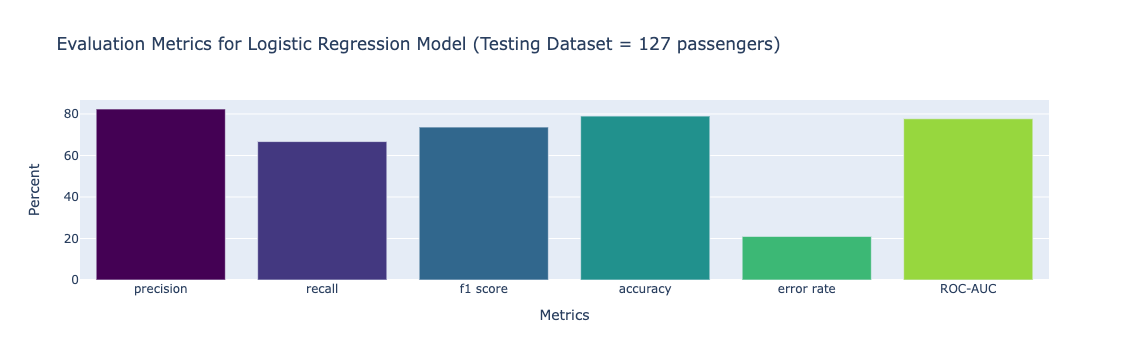

In [159]:
# Convert that into a visualization.
mydata = [go.Bar(
    x=list(evals.keys()),
    y=list(evals.values()),
    marker=dict(color=Viridis[::12])
)]

mylayout = go.Layout(
    title='Evaluation Metrics for Logistic Regression Model (Testing Dataset = 127 passengers)',
    xaxis = {'title': 'Metrics'},
    yaxis = {'title': 'Percent'}, 

)
fig = go.Figure(data=mydata, layout=mylayout)
fig

In [160]:
FPR, TPR, _ = roc_curve(y_test, probabilities)
FPR

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.0125, 0.0125, 0.0125,
       0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.025 , 0.025 , 0.05  ,
       0.0625, 0.075 , 0.075 , 0.075 , 0.075 , 0.1125, 0.1125, 0.15  ,
       0.1875, 0.2   , 0.2   , 0.2625, 0.3   , 0.325 , 0.325 , 0.3375,
       0.3625, 0.4   , 0.425 , 0.4375, 0.45  , 0.45  , 0.475 , 0.475 ,
       0.5   , 0.5125, 0.5125, 0.525 , 0.5375, 0.575 , 0.725 , 0.725 ,
       0.7375, 0.775 , 0.775 , 0.7875, 0.85  , 0.8625, 0.9125, 0.95  ,
       0.975 , 1.    ])

In [161]:
roc_score=round(100*roc_auc_score(y_test, predictions),1)
roc_score

77.7

In [162]:
roc_dict={'FPR':list(FPR), 
          'TPR':list(TPR),
          'y_test':list(y_test), 
          'predictions':[int(i) for i in predictions]
         }

In [44]:
# Save everything we need to reproduce the ROC-AUC figure in plotly dash.
import json
with open('resources/roc_dict.json', 'w') as f:
    json.dump(roc_dict, f)

In [45]:
with open('resources/roc_dict.json') as json_file:
    roc_dict = json.load(json_file)
FPR=roc_dict['FPR']
TPR=roc_dict['TPR']
y_test=pd.Series(roc_dict['y_test'])
predictions=roc_dict['predictions']

In [46]:
# # Save everything we need to reproduce the ROC-AUC figure in plotly dash.
# import json
# file = open('resources/FPR.json', 'wb')
# json.dump(FPR, file)
# file.close()

# file = open('resources/TPR.pkl', 'wb')
# pickle.dump(TPR, file)
# file.close()

# file = open('resources/y_test.pkl', 'wb')
# pickle.dump(y_test, file)
# file.close()

# file = open('resources/predictions.pkl', 'wb')
# pickle.dump(predictions, file)
# file.close()

In [47]:
# ROC-AUC figure

roc_score=round(100*roc_auc_score(y_test, predictions),1)
trace0=go.Scatter(
        x=FPR, 
        y=TPR,
        mode='lines',
        name=f'AUC: {roc_score}',
        marker=dict(color=Viridis[10])
        )
trace1=go.Scatter(
        x=[0,1], 
        y=[0,1],
        mode='lines',
        name='Baseline Area: 50.0',
    marker=dict(color=Viridis[50])
        )
layout=go.Layout(
    title='Receiver Operating Characteristic (ROC): Area Under Curve',
    xaxis={'title': 'False Positive Rate (100-Specificity)','scaleratio': 1,'scaleanchor': 'y'},
    yaxis={'title': 'True Positive Rate (Sensitivity)'}
    )
data=[trace0, trace1]
fig = dict(data=data, layout=layout)
fig

{'data': [Scatter({
      'marker': {'color': '#46307c'},
      'mode': 'lines',
      'name': 'AUC: 77.3',
      'x': [0.0, 0.0, 0.0, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
            0.025, 0.025, 0.025, 0.025, 0.0375, 0.0375, 0.05, 0.05, 0.075, 0.075,
            0.1125, 0.1375, 0.175, 0.1875, 0.1875, 0.2, 0.2125, 0.275, 0.275, 0.3125,
            0.35, 0.375, 0.375, 0.4, 0.4125, 0.425, 0.45, 0.4625, 0.525, 0.525,
            0.5625, 0.5625, 0.575, 0.6, 0.75, 0.7625, 0.8, 0.8125, 0.8125, 0.85,
            0.875, 0.9, 0.95, 1.0],
      'y': [0.0, 0.015873015873015872, 0.06349206349206349, 0.06349206349206349,
            0.07936507936507936, 0.12698412698412698, 0.23809523809523808,
            0.2857142857142857, 0.31746031746031744, 0.42857142857142855,
            0.4603174603174603, 0.49206349206349204, 0.5396825396825397,
            0.5714285714285714, 0.5873015873015873, 0.6031746031746031,
            0.6031746031746031, 0.6190476190476191, 0.619047619047619

In [48]:
# A confusion matrix tells us our false positives and false negatives:
matrix=confusion_matrix(y_test, predictions)
print(matrix)
cm=pd.DataFrame(matrix, columns=['pred: survival', 'pred: death'])
cm[f'n={len(y_test)}']=['actual: survival', 'actual: death']
cm=cm[[f'n={len(y_test)}', 'pred: survival', 'pred: death']]
cm

[[69 11]
 [20 43]]


,n=143,pred: survival,pred: death
0,actual: survival,69,11
1,actual: death,20,43


In [49]:
# Save cm dataframe to a pickle file, for later use in plotly dash app
cm.to_csv('resources/confusion_matrix.csv', index=False)
cm=pd.read_csv('resources/confusion_matrix.csv')
cm

,n=143,pred: survival,pred: death
0,actual: survival,69,11
1,actual: death,20,43


In [50]:
# Display the confusion matrix as a formatted table with Plotly
trace = go.Table(
    header=dict(values=cm.columns,
                line = dict(color='#7D7F80'),
                fill = dict(color=Viridis[55]),
                align = ['left'] * 5),
    cells=dict(values=[cm[f'n={len(y_test)}'], cm['pred: survival'], cm['pred: death']],
               line = dict(color='#7D7F80'),
               fill = dict(color='white'),
               align = ['left'] * 5))

layout = go.Layout(
    title = f'Confusion Matrix: Logistic Regression Model (Testing Dataset)'
)

data = [trace]
fig = dict(data=data, layout=layout)
fig

{'data': [Table({
      'cells': {'align': [left, left, left, left, left],
                'fill': {'color': 'white'},
                'line': {'color': '#7D7F80'},
                'values': [['actual: survival', 'actual: death'], [69, 20], [11,
                           43]]},
      'header': {'align': [left, left, left, left, left],
                 'fill': {'color': '#6bcc5a'},
                 'line': {'color': '#7D7F80'},
                 'values': array(['n=143', 'pred: survival', 'pred: death'], dtype=object)}
  })],
 'layout': Layout({
     'title': {'text': 'Confusion Matrix: Logistic Regression Model (Testing Dataset)'}
 })}

In [51]:
# Feature importance (Logistic Regression)
coeffs1=pd.DataFrame(list(zip(list(X_train.columns), logreg.coef_[0])), columns=['feature', 'coefficient'])
coeffs=coeffs1.sort_values(by='coefficient', ascending=False)

# Format the coefficients.
y_vals=[]
for val in list(coeffs['coefficient']):
    y_vals.append(round(float(val),2))
y_vals

coeffs['coefficient']=y_vals
coeffs

,feature,coefficient
1,female,1.19
3,Cabin Class 1,1.14
11,Mrs.,0.77
6,Cherbourg,0.30
13,VIP,0.13
12,Miss,-0.01
4,Cabin Class 2,-0.02
7,Queenstown,-0.11
0,Siblings and Spouses,-0.27
8,"Age (20, 28]",-0.43


In [52]:
# save the results to a csv file, for later use by plotly dash app.
coeffs.to_csv('resources/coefficients.csv', index=False)

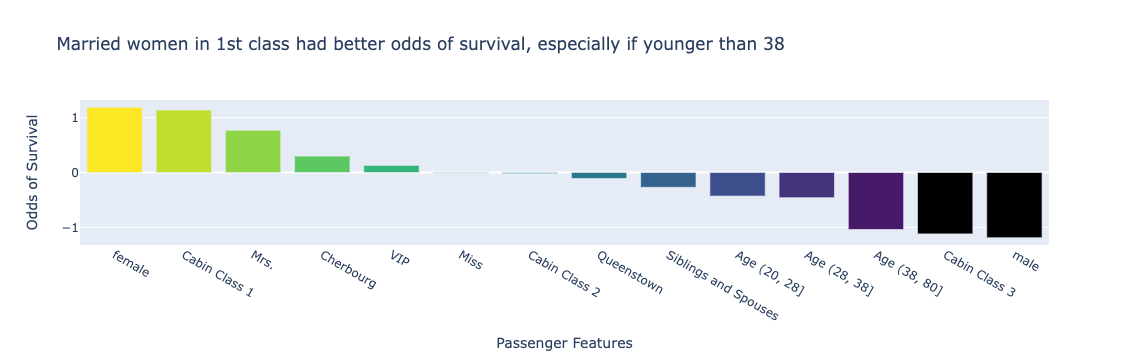

In [53]:
# Let's display that with Plotly.
mydata = [go.Bar(
    x=coeffs['feature'],
    y=coeffs['coefficient'],
    marker=dict(color=Viridis[::-6])
)]

mylayout = go.Layout(
    title='Married women in 1st class had better odds of survival, especially if younger than 38',
    xaxis = {'title': 'Passenger Features'},
    yaxis = {'title': 'Odds of Survival'}, 

)
fig = go.Figure(data=mydata, layout=mylayout)
fig

In [54]:
print(len(probabilities))
print(len(predictions))
print(len(y_test))
print(len(X_test1))

143
143
143
143


In [55]:
X_test1=X_test1.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)
probs=pd.DataFrame(probabilities, columns=['survival_prob'])

In [56]:
# Merge back in the names
final=pd.concat([X_test1, y_test, probs], axis=1)
final.rename(columns={0: "Survived"},inplace=True)

In [57]:
final.shape

(143, 17)

In [58]:
final.head()

,Name,Siblings and Spouses,female,male,Cabin Class 1,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,"Age (20, 28]","Age (28, 38]","Age (38, 80]",Mrs.,Miss,VIP,Survived,survival_prob
0,"Sagesser, Mlle. Emma",0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0.940809
1,"Eustis, Miss. Elizabeth Mussey",1,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0.849084
2,"Taussig, Mr. Emil",1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0.276966
3,"Ryerson, Miss. Emily Borie",2,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0.939488
4,"Sharp, Mr. Percival James R",0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0.229939


In [59]:
final.to_csv('resources/final_probs.csv', index=False)

In [60]:
list(final.columns)

['Name',
 'Siblings and Spouses',
 'female',
 'male',
 'Cabin Class 1',
 'Cabin Class 2',
 'Cabin Class 3',
 'Cherbourg',
 'Queenstown',
 'Age (20, 28]',
 'Age (28, 38]',
 'Age (38, 80]',
 'Mrs.',
 'Miss',
 'VIP',
 'Survived',
 'survival_prob']

In [61]:
mydata=final.drop(['survival_prob'], axis=1)
table=[go.Table(
        header=dict(values=list(mydata.columns)),
        cells=dict(values=list(mydata.loc[5])))]
table

[Table({
     'cells': {'values': ['Thayer, Mr. John Borland Jr', 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]},
     'header': {'values': [Name, Siblings and Spouses, female, male, Cabin Class 1,
                           Cabin Class 2, Cabin Class 3, Cherbourg, Queenstown, Age
                           (20, 28], Age (28, 38], Age (38, 80], Mrs., Miss, VIP,
                           Survived]}
 })]

## Exploring individual predictions

In [62]:
value='Sharp, Mr. Percival James R'
survival=final.loc[3, 'survival_prob']
survival

0.9394879102256058

In [63]:
names=df['Name'].values
names[:5]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry'], dtype=object)

In [64]:
indexs=df['Name'].index.values
indexs[:5]

array([0, 1, 2, 3, 4])

In [65]:
names=df['Name'].values
index=df['Name'].index.values
nameslist = list(zip(indexs, names))
print(nameslist[5])
print(nameslist[5][0])
print(nameslist[5][1])

(5, 'McCarthy, Mr. Timothy J')
5
McCarthy, Mr. Timothy J


In [66]:
options=[{'label': k, 'value': i} for i,k in nameslist]
options[0]

{'label': 'Braund, Mr. Owen Harris', 'value': 0}

In [67]:
value=nameslist[0][0]
value

0

In [68]:
survival=final.loc[value, 'survival_prob']
round(survival*100)

94

In [69]:
final.columns

Index(['Name', 'Siblings and Spouses', 'female', 'male', 'Cabin Class 1',
       'Cabin Class 2', 'Cabin Class 3', 'Cherbourg', 'Queenstown',
       'Age (20, 28]', 'Age (28, 38]', 'Age (38, 80]', 'Mrs.', 'Miss', 'VIP',
       'Survived', 'survival_prob'],
      dtype='object')

## Predict on a single, individual row of data.

In [70]:
final.head()

,Name,Siblings and Spouses,female,male,Cabin Class 1,Cabin Class 2,Cabin Class 3,Cherbourg,Queenstown,"Age (20, 28]","Age (28, 38]","Age (38, 80]",Mrs.,Miss,VIP,Survived,survival_prob
0,"Sagesser, Mlle. Emma",0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0.940809
1,"Eustis, Miss. Elizabeth Mussey",1,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0.849084
2,"Taussig, Mr. Emil",1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0.276966
3,"Ryerson, Miss. Emily Borie",2,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0.939488
4,"Sharp, Mr. Percival James R",0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0.229939


In [71]:
testset=final.drop(["survival_prob", 'Name','Survived'], axis=1)
firstrow=testset.loc[0]
firstrow

Siblings and Spouses    0
female                  1
male                    0
Cabin Class 1           1
Cabin Class 2           0
Cabin Class 3           0
Cherbourg               1
Queenstown              0
Age (20, 28]            1
Age (28, 38]            0
Age (38, 80]            0
Mrs.                    0
Miss                    1
VIP                     0
Name: 0, dtype: int64

In [72]:
myarray=firstrow.values
myarray.shape

(14,)

In [73]:
thisarray=myarray.reshape((1, myarray.shape[0]))
thisarray.shape

(1, 14)

In [74]:
logreg.predict_proba(thisarray)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



array([[0.06594558, 0.93405442]])

In [75]:
logreg.predict(thisarray)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



array([1])

In [76]:
df.columns

Index(['Survived', 'Age', 'Fare', 'Name', 'Siblings and Spouses', 'female',
       'male', 'Cabin Class 1', 'Cabin Class 2', 'Cabin Class 3', 'Cherbourg',
       'Queenstown', 'Southampton', 'Age (1, 20]', 'Age (20, 28]',
       'Age (28, 38]', 'Age (38, 80]', 'Last Name', 'First Name', 'Title',
       'Mr.', 'Mrs.', 'Miss', 'VIP'],
      dtype='object')